# **Tarea Nº 4**
Scope: APIs

Curso:          Fundamentos de Programación en Python para Macroeconomía y Finanzas     
Profesor:       Victor Fuentes Campos     

- Fecha y hora de entrega: Viernes 12 de enero, 11:59pm
- Agregue los nombres de las personas con las que discutió esta tarea: Adriana Arce y Braulio Mundaca
- Envíe su tarea haciendo el `push` de su código a su repo en GitHub Classroom: 

The Central Bank Reserve of Perú (BCRP) holds a list of datasets that are among the most comprehensive for macroeconomic purposes. In this exercise, we'll retrieve data from the [BCRP API](https://estadisticas.bcrp.gob.pe/estadisticas/series/ayuda/api) and explore the impact of pandemics

## Before starting

- You must pull the necessary data using `get` and `requests`
- You are required to apply the concepts learned in the previous sessions (`pandas`, `if`, `loop`, `function`)
- Hint: here is the BCRP url structure for the APIs call:
```html
https://estadisticas.bcrp.gob.pe/estadisticas/series/api/[códigos de series]/[formato de salida]/[periodo inicial]/[periodo final]/[idioma]
```

## The very long run

1. Locate the "Estadísticas de 100 años del BCRP" section in the BCRP´s series data statistics [here](https://estadisticas.bcrp.gob.pe/estadisticas/series/index) and identify the necessary code for the serie **`PBI (Mill S/ 2007)`**. Later, add manually the annual GDP values for 2022 and 2023 (be careful with the units of data). Then, **calculate** the Peruvian annual GDP growth (%) since 1922 to 2023. Finally, plot it using a very simple graph through `matplotlib` and provide critical insights (no more than 100 words)

    Hint1: use `.json()` for exploring the `content`. Your data is inside `["periods"]`
    
    Hint2: the graph must looks something like this: <img src="growth_gdp_long_run.png" max-width="300">
    

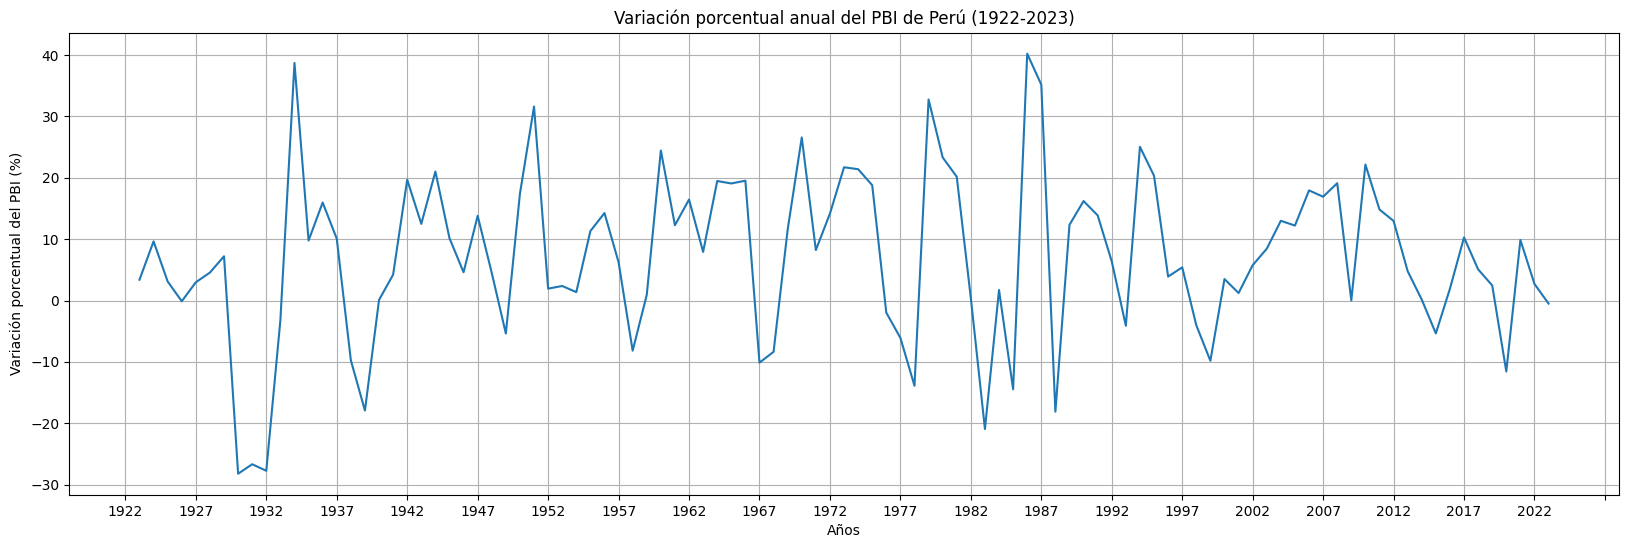

In [35]:
#Importamos
import requests
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker

# Obtén los datos de la API
response = requests.get("https://estadisticas.bcrp.gob.pe/estadisticas/series/api/PD39592DA/json/1921/2022/esp")
data = response.json()

# Extrae los datos del PBI
pbi_data = [{"year": item["name"], "value": float(item["values"][0])} for item in data["periods"]]

# Crea el DataFrame
df = pd.DataFrame(pbi_data)

# Crea un diccionario para mapear los nombres de los meses en español a inglés
month_map = {'Ene': 'Jan', 'Feb': 'Feb', 'Mar': 'Mar', 'Abr': 'Apr', 'May': 'May', 'Jun': 'Jun',
             'Jul': 'Jul', 'Ago': 'Aug', 'Set': 'Sep', 'Oct': 'Oct', 'Nov': 'Nov', 'Dic': 'Dec'}

# Reemplaza los nombres de los meses en la columna 'year'
df['year'] = df['year'].replace(month_map, regex=True)

# Calcula la variación porcentual y almacénala en una nueva columna 'pct_change'
df['var.'] = df['value'].pct_change()*100


#Incorporamos los datos del año 2022 y 2023
new_data = pd.DataFrame({
    'year': ['2022', '2023'],
    'var.': [2.7, -0.5]  
})

# Une el nuevo DataFrame con el original
df = pd.concat([df, new_data]).reset_index(drop=True)

# Crea una nueva columna 'year_only' que contenga solo el año
df['year_only'] = df['year']#.dt.year

# Agrupa los datos por año y calcula la media de 'var.'
df_yearly = df.groupby('year_only')[['var.']].mean()

# Crea la figura y el eje
fig, ax = plt.subplots(figsize=(20, 6))

# Dibuja los datos
ax.plot(df_yearly.index, df_yearly['var.'])

# Configura el formato de las fechas en el eje x
years = mdates.YearLocator()   # cada año
years_fmt = mdates.DateFormatter('%Y')
ax.xaxis.set_major_locator(ticker.MultipleLocator(5))
#ax.set_xlim([1922, df.index.max()])

# Configura las etiquetas y el título
ax.set_xlabel('Años')
ax.set_ylabel('Variación porcentual del PBI (%)')
ax.set_title('Variación porcentual anual del PBI de Perú (1922-2023)')

# Muestra la cuadrícula
ax.grid(True)

# Muestra el gráfico
plt.show()

## The hitman

2. Retrieve the up-to-date data for the monthly GDP in index (2007=100) from this [link](https://estadisticas.bcrp.gob.pe/estadisticas/series/mensuales/producto-bruto-interno-y-demanda-interna-variaciones-indice-2007). Then, calculate the the 5-year average monthly growth previous to the pandemics (ending in Feb-2020) for the 12-month rolling mean of the index, and project the alternative scenario of the Peruvian economy without the COVID-19. Then plot them out and provide insight from the gap between the real data and the pre-pandemic trend.

    Hint1: You may use the regression type of your election, but the OLS is recommended. 
    
    Hint2: Your plot should look somethig like this. You aren´t required to add flags/annotations/texts inside the graph <img src="growth_gdp_pandemics.png" max-width="300">

    Hint3: For more details about calculation, review this post from [The Economist](https://www.economist.com/graphic-detail/2021/10/28/americas-post-covid-economic-recovery-suffers-a-setback)
    


In [36]:
# Importamos
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import numpy as np

#Extraemos la serie
URL ='https://estadisticas.bcrp.gob.pe/estadisticas/series/mensuales/resultados/PN01770AM/html'
BCRP = pd.read_html(URL) 
serie = BCRP[1]
serie


,Fecha,Producto bruto interno y demanda interna (índice 2007=100) - PBI
0,Ene03,73.2
1,Feb03,71.1
2,Mar03,74.3
3,Abr03,80.7
4,May03,83.2
...,...,...
245,Jun23,177.3
246,Jul23,175.5
247,Ago23,178.1
248,Sep23,180.0


In [37]:
#Delimitamos la serie por la pandemia
serie_prepandemica = serie[145:206].copy()  # Hacemos una copia
serie_prepandemica.loc[:, 'Tiempo'] = range(1, len(serie_prepandemica) + 1)
serie_prepandemica = serie_prepandemica.reset_index(drop=True)


In [38]:
#Tenemos nuestra serie contrafactual
serie_prepandemica2=serie[145:250].copy()  # Hacemos una copia
serie_prepandemica2.loc[:, 'Tiempo'] = range(1, len(serie_prepandemica2) + 1)
serie_prepandemica2 = serie_prepandemica2.reset_index(drop=True)

#Obtenemos el logaritmo para desestacionaliar
serie_prepandemica2['Log_PBI'] = np.log1p(serie_prepandemica2['Producto bruto interno y demanda interna (índice 2007=100) - PBI'])
serie_prepandemica2
serie_prepandemica['Crecimiento mensual'] = serie_prepandemica['Producto bruto interno y demanda interna (índice 2007=100) - PBI'].pct_change() * 100
serie_prepandemica['Media_movil'] = serie_prepandemica['Crecimiento mensual'].rolling(window=12).mean()
serie_prepandemica


,Fecha,Producto bruto interno y demanda interna (índice 2007=100) - PBI,Tiempo,Crecimiento mensual,Media_movil
0,Feb15,137.5,1,NaN,NaN
1,Mar15,148.3,2,7.854545,NaN
2,Abr15,152.0,3,2.494943,NaN
3,May15,150.2,4,-1.184211,NaN
4,Jun15,150.6,5,0.266312,NaN
...,...,...,...,...,...
56,Oct19,176.3,57,2.262181,0.423777
57,Nov19,174.2,58,-1.191151,0.392502
58,Dic19,189.6,59,8.840413,0.296849
59,Ene20,162.4,60,-14.345992,0.436820


In [39]:
#Realizamos la regresion
regresion = sm.OLS(serie_prepandemica['Producto bruto interno y demanda interna (índice 2007=100) - PBI'], sm.add_constant(serie_prepandemica['Tiempo'])).fit()
serie_prepandemica['Tendencia_Previa'] = regresion.predict(sm.add_constant(serie_prepandemica['Tiempo']))
regresion.summary()
#Creamos un dataframe que contenga los datos de la regresion y que prediga futuros indices de PBI si es que no hubiera existido la pandemia
serie_sin_pandemia = pd.DataFrame({'X': np.arange(1, 106)})
serie_sin_pandemia['Y'] = regresion.predict(sm.add_constant(serie_sin_pandemia['X']))
#Obtenemos el logaritmo para desestacionalizar
serie_sin_pandemia['Log_Y'] = np.log1p(serie_sin_pandemia['Y'])
serie_sin_pandemia


,X,Y,Log_Y
0,1,149.094077,5.011262
1,2,149.516843,5.014075
2,3,149.939609,5.016880
3,4,150.362374,5.019677
4,5,150.785140,5.022466
...,...,...,...
100,101,191.370650,5.259424
101,102,191.793416,5.261619
102,103,192.216182,5.263810
103,104,192.638948,5.265995


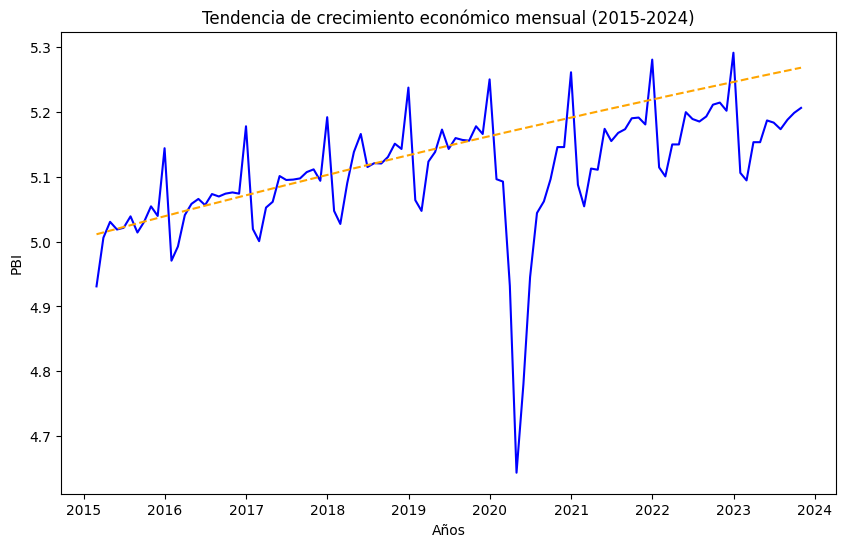

In [40]:
import matplotlib.dates as mdates

# Asegúrate de que 'Tiempo' es una columna de fechas
serie_prepandemica2['Tiempo'] = pd.date_range(start='2015-02-01', periods=len(serie_prepandemica2), freq='M')
serie_sin_pandemia['X'] = pd.date_range(start='2015-02-01', periods=len(serie_sin_pandemia), freq='M')

#Hacemos el comparativo desestacionalizado
plt.figure(figsize=(10, 6))
plt.plot(serie_prepandemica2['Tiempo'], serie_prepandemica2['Log_PBI'], label='PBI', color='blue')
plt.plot(serie_sin_pandemia['X'], serie_sin_pandemia['Log_Y'], label='Tendencia Previa a la Pandemia (OLS)', linestyle='--', color='orange')

# Formatea el eje x para mostrar las fechas
ax = plt.gca()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.set_title('Tendencia de crecimiento económico mensual (2015-2024)')

plt.xlabel('Años')
plt.ylabel('PBI')
plt.show()


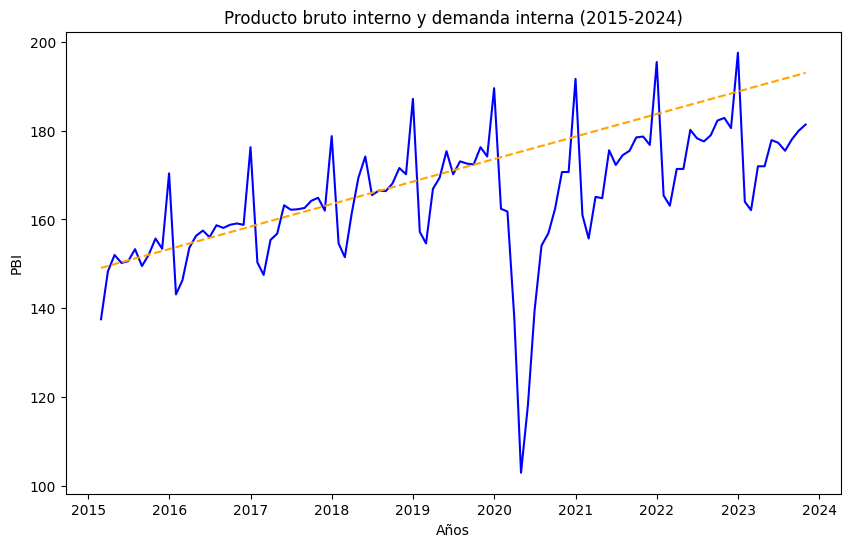

In [41]:
#Importamos
import matplotlib.dates as mdates

# Asegúrate de que 'Tiempo' es una columna de fechas
serie_prepandemica2['Tiempo'] = pd.date_range(start='2015-02-01', periods=len(serie_prepandemica2), freq='M')
serie_sin_pandemia['X'] = pd.date_range(start='2015-02-01', periods=len(serie_sin_pandemia), freq='M')

#Hacemos el comparativo desestacionalizado
plt.figure(figsize=(10, 6))
plt.plot(serie_prepandemica2['Tiempo'], serie_prepandemica2['Producto bruto interno y demanda interna (índice 2007=100) - PBI'], label='PBI', color='blue')
plt.plot(serie_sin_pandemia['X'], serie_sin_pandemia['Y'], label='Tendencia Previa a la Pandemia (OLS)', linestyle='--', color='orange')

# Formatea el eje x para mostrar las fechas
ax = plt.gca()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.set_title('Producto bruto interno y demanda interna (2015-2024)')

plt.xlabel('Años')
plt.ylabel('PBI')
plt.show()

## The winners

- Based on the [Nasdaq Stock Screener](https://www.nasdaq.com/market-activity/stocks/screener), identify the three largest companies in the three larger sectors defined by market cap
- Elaborate a list/dictionary/series (what ever you think is more suitable) containing all tickers (or symbols) and sectors from these companies.
- So far, you can download data from Nasdaq, web scrape it or copy it manually. It doesn´t matter
- Then, use `yfinance` library to retrieve the market data for all the 9 firms
- Construct a table with the most common *institucional holders* by sector. Is there any interesting pattern? Hint: loop the `institutional_holders` from `yfinance`
- Calculate the distribution of the daily percentage returns for the 3 larger companies (defined by market cap) along the last 5 years. Plot your results (feel free to find the most appealing way to represent them) and provide critical insights

$$
  percentage\_return_{t} = \frac{price_t-price_{t-1}}{price_t}*100+dividends (\%)
$$

- Hint1: you can find the `dividens` through the `yfinance`'s 
`Ticker()`
- Hint2: some firms may not be paying dividends

In [42]:
import yfinance as yf
import pandas as pd

# Importamos el archivo csv
Nasdaq_data = pd.read_csv(r"NasdaqStockScreener.csv")
Nasdaq_list = Nasdaq_data.values.tolist()

#Convertimos la lista en un DataFrame
df = pd.DataFrame(Nasdaq_list, columns=['Symbol', 'Name', 'Last Sale','Net Change','% Change','Market Cap','Country', 'IPO Year', 'Volume', 'Sector', 'Industry'])

#Identificamos las 3 empresas más grandes en los 3 mayores sectores definidos por el Market Cap
# 1. Ordena el DataFrame por 'Sector' y 'Market Cap' en orden descendente
df_sorted = df.sort_values(by=['Sector', 'Market Cap'], ascending=False)

# 2. Agrupa por 'Sector' y toma las tres primeras filas de cada grupo
df_largest_companies = df_sorted.groupby('Sector').head(3)

# 3. Ahora, para obtener los tres sectores más grandes, puedes hacer lo siguiente:
df_sector_sizes = df.groupby('Sector')['Market Cap'].sum()
df_largest_sectors = df_sector_sizes.nlargest(3)

# 4. Y para obtener las tres empresas más grandes en estos sectores:
df_largest_companies_in_largest_sectors = df_largest_companies[df_largest_companies['Sector'].isin(df_largest_sectors.index)]
df_largest_companies_in_largest_sectors

#Elabore una diccionario con todos los tickers (o símbolos) y sectores de estas empresas(las que acabamos de hallar)
Symbol_sectors_dict = df_largest_companies_in_largest_sectors.set_index('Symbol')['Sector'].to_dict()
Symbol_sectors_dict

#Utilice la biblioteca yfinance para recuperar los datos de mercado de las 9 empresas
# 1. Define los tickers de las empresas que te interesan
Symbol = ["AAPL", "MSFT", "GOOG", "HSBC", "JPM", "BAC", "AMZN", "TSLA", "V"]

# 2. Descarga los datos de las acciones
data = yf.download(Symbol, start="2019-01-12", end="2024-01-11") #Elegí los 5 últimos años para el análisis debido a la indicación del ejericio

# 3. Ahora 'data' es un DataFrame que contiene los datos de las acciones de las empresas
data

#Construya una tabla con los titulares institucionales más comunes por sector. 
# 1. Lista de símbolos de acciones por sector
sectores = {
    'Technology': ['AAPL', 'MSFT', 'GOOG'],
    'Finance': ['HSBC', 'JPM', 'BAC'],
    'Consumer Discretionary': ['AMZN', 'TSLA', 'V'],
}

# 2. DataFrame para almacenar los resultados
resultados = []

for sector, acciones in sectores.items():
    for accion in acciones:
        Symbol = yf.Ticker(accion)
        holders = Symbol.institutional_holders

        if holders is not None and not holders.empty:
            # Añade el sector y el símbolo de la acción a los datos
            holders['Sector'] = sector
            holders['Symbol'] = accion

            # Añade los datos al DataFrame de resultados
            resultados.append(holders)

# 3. Combina todos los DataFrames en uno solo
resultados_df = pd.concat(resultados)

# 4. Muestra los resultados
print(resultados_df)

[*********************100%%**********************]  9 of 9 completed


   Date Reported                                Holder  pctHeld      Shares  \
0     2023-06-30                    Vanguard Group Inc   0.0834  1303688506   
1     2023-06-30                        Blackrock Inc.   0.0665  1039640859   
2     2023-06-30               Berkshire Hathaway, Inc   0.0586   915560382   
3     2023-06-30              State Street Corporation   0.0370   578897858   
4     2023-06-30                              FMR, LLC   0.0196   307066638   
..           ...                                   ...      ...         ...   
5     2023-06-30         Price (T.Rowe) Associates Inc   0.0293    47027268   
6     2023-06-30         Geode Capital Management, LLC   0.0207    33239315   
7     2023-06-30                Alliancebernstein L.P.   0.0159    25567374   
8     2023-06-30           Bank of America Corporation   0.0153    24550972   
9     2023-06-30  Massachusetts Financial Services Co.   0.0138    22094578   

           Value                  Sector Symbol  
0

In [43]:
#Identificamos las empresas más grandes por capitalización de mercado
df_largest_companies_by_market_cap = df_sorted.groupby('Market Cap').head(3)
df_largest_companies_by_market_cap

,Symbol,Name,Last Sale,Net Change,% Change,Market Cap,Country,IPO Year,Volume,Sector,Industry
1216,NEE,NextEra Energy Inc. Common Stock,$60.72,-1.56,-2.505%,1.245797e+11,United States,NaN,10685214,Utilities,Electric Utilities: Central
1628,SO,Southern Company (The) Common Stock,$70.58,-1.25,-1.74%,7.697591e+10,United States,NaN,3406743,Utilities,Power Generation
569,DUK,Duke Energy Corporation (Holding Company) Comm...,$97.15,-2.13,-2.145%,7.487464e+10,United States,NaN,3063213,Utilities,Power Generation
1920,WM,Waste Management Inc. Common Stock,$179.22,0.04,0.022%,7.218541e+10,United States,NaN,1176387,Utilities,Environmental Services
622,EPD,Enterprise Products Partners L.P. Common Stock,$26.80,-0.10,-0.372%,5.820636e+10,United States,NaN,5651348,Utilities,Natural Gas Distribution
...,...,...,...,...,...,...,...,...,...,...,...
1883,VYX,NCR Voyix Corporation Common Stock,$15.86,-0.32,-1.978%,2.239432e+09,United States,NaN,1690864,NaN,NaN
1094,LVWR,LiveWire Group Inc. Common Stock,$11.02,0.15,1.38%,2.232032e+09,United States,2022.0,25462,NaN,NaN
611,ENLT,Enlight Renewable Energy Ltd. Ordinary Shares,$18.05,0.07,0.389%,2.123582e+09,Israel,2023.0,52319,NaN,NaN
808,GPCR,Structure Therapeutics Inc. American Depositar...,$45.37,-0.04,-0.088%,2.104553e+09,United States,2023.0,489814,NaN,NaN


In [44]:
#Sería NEE, SO y DUK
nee=yf.Ticker('NEE')
so=yf.Ticker('SO')
duk=yf.Ticker('DUK')
nee_history=nee.history("5y")
nee_history['Retorno Porcentual'] = ((nee_history['Close'] - nee_history['Close'].shift(1)) / nee_history['Close'].shift(1) * 100) + nee_history['Dividends']
nee_history

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Retorno Porcentual
Date,,,,,,,,
2019-01-14 00:00:00-05:00,39.000265,39.000265,37.823246,38.243130,15355600,0.0,0.0,NaN
2019-01-15 00:00:00-05:00,38.278867,39.266046,38.135928,39.022602,9261200,0.0,0.0,2.038202
2019-01-16 00:00:00-05:00,38.866268,39.065043,38.600488,39.013672,7059200,0.0,0.0,-0.022885
2019-01-17 00:00:00-05:00,39.114176,39.290616,38.960069,39.194580,8200800,0.0,0.0,0.463705
2019-01-18 00:00:00-05:00,39.397811,39.444715,39.109699,39.328575,7414400,0.0,0.0,0.341871
...,...,...,...,...,...,...,...,...
2024-01-08 00:00:00-05:00,61.779999,63.060001,61.590000,62.919998,7766600,0.0,0.0,1.353087
2024-01-09 00:00:00-05:00,62.939999,63.040001,61.889999,62.009998,6921600,0.0,0.0,-1.446281
2024-01-10 00:00:00-05:00,62.020000,62.730000,61.900002,62.279999,8100100,0.0,0.0,0.435414


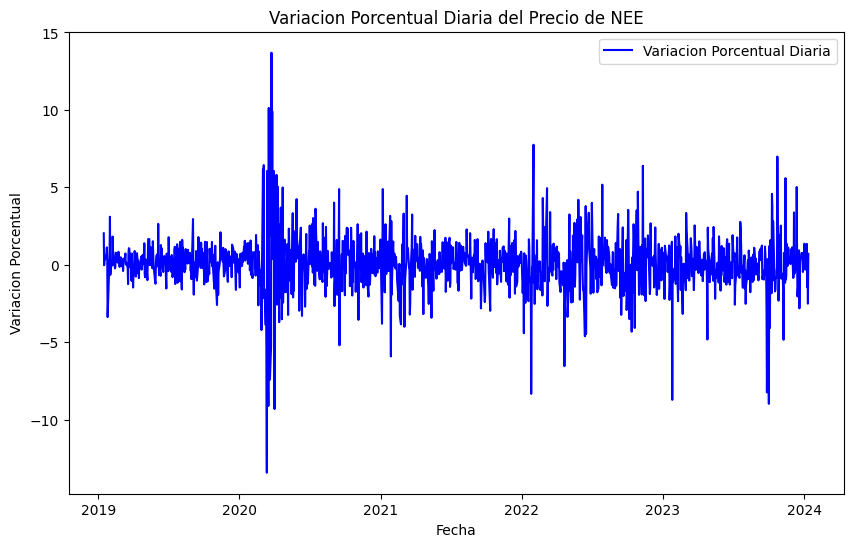

In [45]:
plt.figure(figsize=(10, 6))
plt.plot(nee_history.index, nee_history['Retorno Porcentual'], label='Variacion Porcentual Diaria', color='blue')
plt.title('Variacion Porcentual Diaria del Precio de NEE')
plt.xlabel('Fecha')
plt.ylabel('Variacion Porcentual')
plt.legend()
plt.show()

In [46]:
so_history=so.history("5y")
so_history['Retorno Porcentual'] = ((so_history['Close'] - so_history['Close'].shift(1)) / so_history['Close'].shift(1) * 100) + so_history['Dividends']
so_history

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Retorno Porcentual
Date,,,,,,,,
2019-01-14 00:00:00-05:00,37.544514,37.763978,37.024305,37.520130,6328900,0.0,0.0,NaN
2019-01-15 00:00:00-05:00,37.455104,38.276059,37.446974,38.032211,5433100,0.0,0.0,1.364817
2019-01-16 00:00:00-05:00,37.820871,38.154131,37.601407,38.097233,5475300,0.0,0.0,0.170964
2019-01-17 00:00:00-05:00,38.089107,38.292314,37.902157,38.259800,3578600,0.0,0.0,0.426716
2019-01-18 00:00:00-05:00,38.284191,38.397990,38.113498,38.381733,4015400,0.0,0.0,0.318697
...,...,...,...,...,...,...,...,...
2024-01-08 00:00:00-05:00,71.500000,72.180000,71.180000,72.160004,3296400,0.0,0.0,0.768053
2024-01-09 00:00:00-05:00,71.699997,72.010002,71.339996,71.870003,3073600,0.0,0.0,-0.401886
2024-01-10 00:00:00-05:00,71.989998,71.989998,71.349998,71.830002,2563200,0.0,0.0,-0.055657


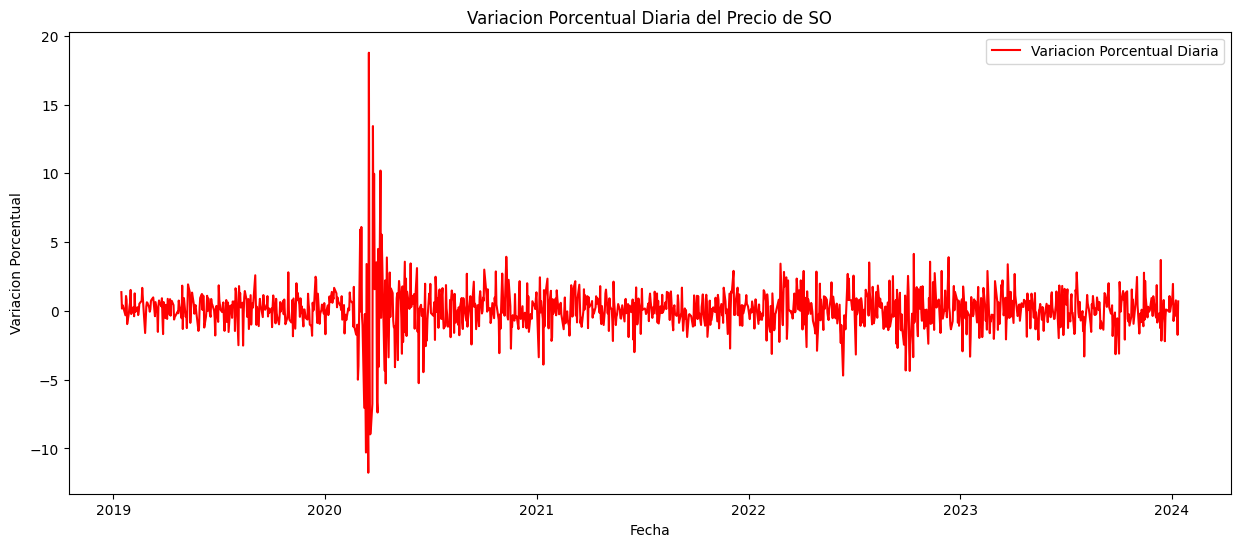

In [47]:
plt.figure(figsize=(15, 6))
plt.plot(so_history.index, so_history['Retorno Porcentual'], label='Variacion Porcentual Diaria', color='red')
plt.title('Variacion Porcentual Diaria del Precio de SO')
plt.xlabel('Fecha')
plt.ylabel('Variacion Porcentual')
plt.legend()
plt.show()

In [48]:
duk_history=duk.history("5y")
duk_history['Retorno Porcentual'] = ((duk_history['Close'] - duk_history['Close'].shift(1)) / duk_history['Close'].shift(1) * 100) + duk_history['Dividends']
duk_history

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Retorno Porcentual
Date,,,,,,,,
2019-01-14 00:00:00-05:00,68.636342,68.636342,67.122304,68.099106,3931000,0.0,0.0,NaN
2019-01-15 00:00:00-05:00,68.050267,69.564305,67.830490,69.303825,2722900,0.0,0.0,1.769068
2019-01-16 00:00:00-05:00,68.961950,69.499185,68.652626,69.409645,2279100,0.0,0.0,0.152690
2019-01-17 00:00:00-05:00,69.425932,69.816648,69.124751,69.710831,1895700,0.0,0.0,0.433925
2019-01-18 00:00:00-05:00,69.955039,70.020154,69.360817,69.678276,2842600,0.0,0.0,-0.046700
...,...,...,...,...,...,...,...,...
2024-01-08 00:00:00-05:00,98.379997,99.440002,98.059998,99.389999,2453400,0.0,0.0,0.862592
2024-01-09 00:00:00-05:00,98.750000,99.389999,98.519997,99.089996,2024900,0.0,0.0,-0.301844
2024-01-10 00:00:00-05:00,99.500000,99.919998,99.099998,99.279999,3076700,0.0,0.0,0.191747


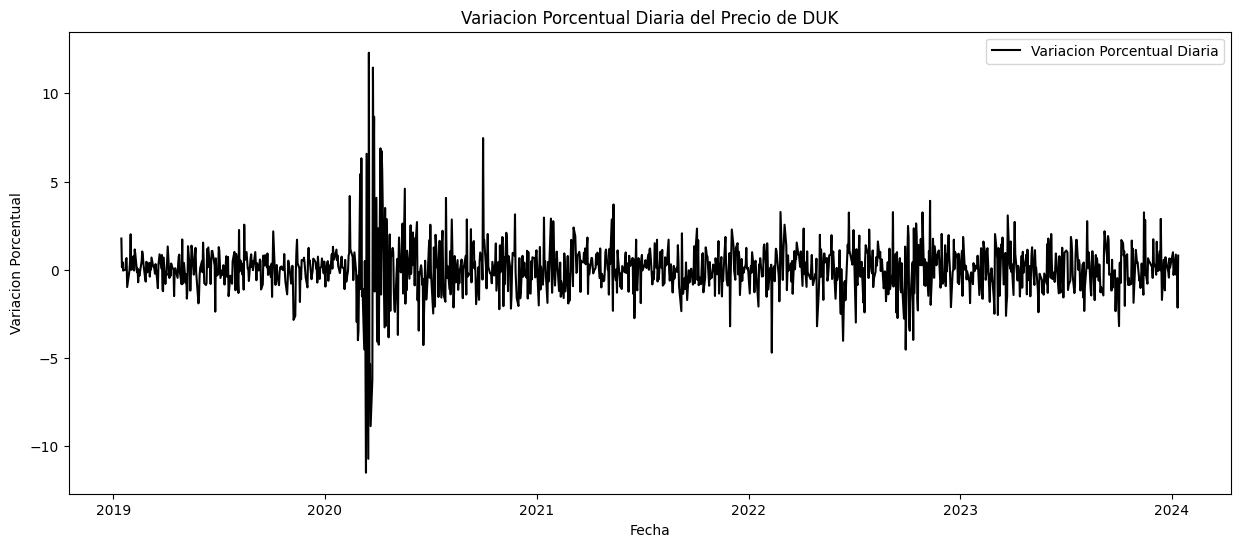

In [49]:
plt.figure(figsize=(15, 6))
plt.plot(duk_history.index, duk_history['Retorno Porcentual'], label='Variacion Porcentual Diaria', color='black')
plt.title('Variacion Porcentual Diaria del Precio de DUK')
plt.xlabel('Fecha')
plt.ylabel('Variacion Porcentual')
plt.legend()
plt.show()

In [50]:
#¿Hay algún patrón interesante?